# First Notes

Please do not run the file as whole, as some cells include some irrelevant code that was created for testing some examples. The cells to be ignored are noted by a **BEGIN:** and **END;** notations.

First, let's go through the imports we'll need for this session. I’ll need RDkit for molecular conversion and fingerprints calculation, numpy for and data management and numpy arrays, Scikit-learn for standardisation and data set splitting as well as Keras for the neural network building and training.

In [15]:
from __future__ import print_function
from rdkit import Chem

# Reading data

Reading a set of molecules an `SDMolSupplier` from rdkit.<br>
In the [getting started](https://www.rdkit.org/docs/GettingStartedInPython.html) documentation there're two these two different suppliers:
* `rdkit.Chem.rdmolfiles.SDMolSupplier`
* `rdkit.Chem.rdmolfiles.SmilesMolSupplier`

We're gonna be using the `SDMolSupplier`...

In [16]:
## Read the file
supplier = Chem.SDMolSupplier('data/cas_4337.sdf')
len(supplier)

4337

We have 4337 molecules in the data set:
A good practice is to test each molecule to see if it was correctly read before working with it:

In [3]:
for mol in supplier:
    if mol is None:
        print("a None molecule was found!")
        
## if the output is empty the data is fine.

# Calculating Morgan fingerprints

We're going to go trough two steps:<br>

First, we'll obtain the training samples, which are going to be the bits value returned by the function `AllChem.GetMorganFingerprintAsBitVect`.<br>This is typically the output of calculating the morgan fingerprints for each molecule. Please refer to the subsection '**Explaining bits from Morgan Fingerprints**' to understand the output.<br>
After that we'd only need to turn it to a numpy array, so that we can pass it to Keras's sequential model. Keras's model expects the training set to be either a numpy array (if the model has a single input), or list of Numpy arrays (if the model has multiple inputs).

<br>
<br>

> **\_\_TASK\_\_:** for each molecule calculate MorganFingerprints (with radius <b>3</b>) and size **~2048** (rdkit has also a nice easy function for that)

In [5]:
import numpy as np
from rdkit.Chem import AllChem

In [5]:
info = {} # will be mutated in the next function
## calculate the Morgan Fingerprints for every molecule in the supplier
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048, bitInfo=info) for mol in supplier]
## convert it from bit vector to NumPy array
fingerprints = np.array(fingerprints)

fingerprints.shape
# OUTPUT: (4337, 2048)

(4337, 2048)

### `bitsInfo` - Explaining bits from Morgan Fingerprints

> **\_\_TASK\_\_:** Important! when you calculate the Fingerprints, save which atoms where responsible for the activation of the fingerprint (rdkit can also do that)

Information about which atoms are contributing to the activation of the fingerprint is stored in the dictionary `bitsInfo`. The dictionary provided is populated with one entry per bit set in the fingerprint, <u>the keys are the bit ids</u>, <u>the values are lists of (atom index, radius) tuples</u>. Let's have a quick look on the dictionary in `info`:

In [6]:
info

{97: ((14, 0),),
 191: ((10, 1),),
 263: ((4, 2),),
 314: ((7, 1), (9, 1)),
 325: ((15, 3),),
 336: ((2, 2), (3, 2)),
 389: ((17, 2),),
 484: ((6, 3), (8, 3)),
 606: ((11, 2),),
 650: ((5, 0), (7, 0), (9, 0)),
 689: ((1, 1),),
 703: ((12, 2), (13, 2)),
 807: ((1, 0),),
 811: ((6, 2), (8, 2)),
 856: ((11, 3),),
 905: ((0, 3),),
 993: ((0, 2),),
 1019: ((0, 0),),
 1034: ((2, 1), (3, 1)),
 1060: ((6, 1), (8, 1)),
 1077: ((10, 2),),
 1088: ((15, 1), (16, 1), (17, 1)),
 1114: ((6, 0), (8, 0)),
 1152: ((4, 0),),
 1199: ((15, 2), (16, 2)),
 1216: ((1, 3),),
 1327: ((10, 3),),
 1380: ((2, 0), (3, 0), (10, 0), (11, 0)),
 1460: ((12, 3),),
 1642: ((4, 3),),
 1645: ((11, 1),),
 1682: ((1, 2),),
 1717: ((14, 1),),
 1750: ((12, 1), (13, 1)),
 1771: ((0, 1),),
 1816: ((4, 1),),
 1873: ((12, 0), (13, 0), (15, 0), (16, 0), (17, 0)),
 1917: ((5, 1),),
 1947: ((17, 3),),
 2037: ((2, 3),)}

<br>

Interpreting the results above:

```
97: ((14, 0),),
191: ((10, 1),),
314: ((7, 1), (9, 1)),
```

* bit 97 is set once: by atom 14 with radius 0.
* bit 191 is set also once: by atom 10, with radius 1.
* bit 314, on the other hand, is set twice: once by atom 7 and once with atom 9, each with radius 1.

<br>

And there we go. Now have succefully extracted the training samples that are ready to be passed to the model.

<br>

## Training And Validation Samples

Second, I'd like to take a moment to split the samples we have into training samples and validation samples. It's important to note that the model is not supposed to learn on the validation samples (In another word, samples in the validation set are not supposed to appear in the training set), therefore we'd need to subset the fingerprints NumPy array at hand.

For that purpose, we have randomly picked the following indices of molecules.<br>
*In the following, I'll be using the alias `valid_`, for anything that's related to the validation set, in order to avoid lengthy variable names.*

In [7]:
## KAREEM: these molecules I got from Kristina!
val_ids = [6,   10,   29,   32,   42,   58,   72,   83,   98,  100,  128, 
        145,  148,  168,  171,  205,  208,  237,  244,  285,  290,  291,
         300,  312,  332,  334,  335,  347,  356,  369,  371,  377,  407,
         424,  456,  458,  470,  472,  486,  514,  515,  528,  557,  563,
         599,  610,  616,  628,  640,  701,  704,  722,  764,  794,  818,
         821,  840,  850,  856,  859,  874,  878,  882,  898,  901,  925,
         936,  945,  957,  974,  977, 1013, 1019, 1030, 1038, 1047, 1049,
        1072, 1073, 1100, 1159, 1168, 1187, 1190, 1194, 1201, 1202, 1233,
        1247, 1258, 1264, 1273, 1283, 1288, 1300, 1302, 1319, 1339, 1349,
        1402, 1413, 1416, 1422, 1426, 1435, 1454, 1465, 1483, 1502, 1513,
        1515, 1520, 1548, 1576, 1604, 1606, 1621, 1650, 1695, 1696, 1711,
        1714, 1716, 1725, 1743, 1746, 1752, 1780, 1788, 1794, 1799, 1813,
        1826, 1866, 1886, 1901, 1903, 1921, 1929, 1940, 1969, 1970, 1997,
        1998, 2008, 2010, 2011, 2018, 2023, 2046, 2060, 2064, 2080, 2081,
        2131, 2171, 2182, 2203, 2212, 2224, 2231, 2241, 2246, 2283, 2294,
        2295, 2297, 2327, 2329, 2331, 2349, 2357, 2360, 2365, 2397, 2413,
        2417, 2418, 2421, 2448, 2467, 2510, 2516, 2528, 2533, 2549, 2562,
        2601, 2604, 2606, 2609, 2611, 2632, 2644, 2653, 2677, 2682, 2685,
        2692, 2703, 2708, 2714, 2719, 2726, 2732, 2759, 2761, 2776, 2780,
        2817, 2818, 2829, 2837, 2857, 2858, 2884, 2899, 2902, 2905, 2911,
        2939, 2975, 2977, 2986, 3007, 3009, 3018, 3024, 3038, 3066, 3087,
        3098, 3107, 3117, 3122, 3139, 3157, 3161, 3164, 3217, 3223, 3233,
        3263, 3265, 3271, 3290, 3295, 3307, 3313, 3317, 3321, 3382, 3384,
        3388, 3400, 3409, 3412, 3419, 3423, 3449, 3470, 3487, 3488, 3503,
        3509, 3511, 3539, 3562, 3626, 3637, 3654, 3662, 3663, 3668, 3671,
        3688, 3689, 3695, 3710, 3726, 3743, 3744, 3782, 3791, 3794, 3808,
        3809, 3841, 3849, 3874, 3910, 3912, 3925, 3945, 3950, 3958, 3959,
        3962, 3964, 3967, 3978, 3993, 4009, 4010, 4055, 4057, 4085, 4089,
        4096, 4099, 4107, 4112, 4129, 4135, 4151, 4155, 4196, 4209, 4216,
        4234, 4236, 4251, 4267, 4283, 4317, 4326, 4335

]

train_samples = []
valid_samples = []
for i in range(len(fingerprints)):
    if i in val_ids:
        valid_samples.append(fingerprints[i])
    else:
        train_samples.append(fingerprints[i])
train_samples = np.array(train_samples)
valid_samples = np.array(valid_samples)


# train_samples.shape
# (4010, 2048)
# valid_samples.shape
# (327, 2048)

## Training And Validation Labels

Now that we've got the the bits for both the training samples as well as for the validation samples ready, we still have one last thing to do before we start building the model: extract the labels to have a target for our predictions.

The property that we want to extract out of the list, is whether or not the 'Ames test Categorisation' is a mutagen.

* 1 for mutagen 
* 0 for nonmutagen

In [8]:
targets = []
for mol in supplier:
    if mol.GetProp("Ames test categorisation") == "mutagen":
        targets.append(1)
    else:
        targets.append(0)
        
# len(targets)
# 4337

train_labels = []
valid_labels = []
for i in range(len(targets)):
    if i in val_ids:
        valid_labels.append(targets[i])
    else:
        train_labels.append(targets[i])

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)

# train_labels.shape
# (4010,)
# valid_labels.shape
# (327,)

### Standard Scaling

Finally we have everything ready to pass to the model.
However, the last step in preparing data is to apply Standard Scaling, because the model cannot learn on some arbitrary numbers. Additionally, I'd need to scale down the validation samples too.

In [9]:
from sklearn.preprocessing import StandardScaler
#Scale fingerprints to unit variance and zero mean
st = StandardScaler()
train_samples = st.fit_transform(train_samples)
valid_samples = st.transform(valid_samples)

/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Model's Architecture

From before we know that our data shape is `(4337, 2048)`, which means that the first layer in our model expects an input size of $2048$.<br>
The following layers, on the other hand, can deduce their input size from the previous layer. For instance, the output size of the first layer in my model is 5, beginning with the second layer, I don't need to specify the input size, because the layer can deduce that alone.

In [1]:
# to suppress the FutureWarning: conversion of the second argument of issubdtype 
# from 'float' to 'np.floatin' is deprecated
import os

import numpy as np
# importing all libraries that we'd need
from keras import backend
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.metrics import categorical_crossentropy

from sklearn import cross_validation
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores

## for Grid Search
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

Using TensorFlow backend.
/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Run the following cell, in case you don't want to recalculate the data.

In [2]:
train_samples = np.loadtxt("data/train_samples.txt", delimiter=' ', comments='# ', encoding=None)
train_labels = np.loadtxt("data/train_labels.txt", delimiter=' ', comments='# ', encoding=None)
valid_samples = np.loadtxt("data/valid_samples.txt", delimiter=' ', comments='# ', encoding=None)
valid_labels = np.loadtxt("data/valid_labels.txt", delimiter=' ', comments='# ', encoding=None)

In [4]:
train_samples.shape[1]

2048

In [5]:
backend.clear_session()
model = Sequential()
model.add(Dense(units=1024, input_dim=train_samples.shape[1], activation='relu', kernel_initializer='uniform'))
model.add(Dropout(0.3))
model.add(Dense(units=512, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units=512, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

And I used the fasted learning rate possible because running 500 epochs takes relatively long time $(\approx1.5\,min)$ on my 2017 machine. For optimizers, I used standard SGD, which <...>.

In [6]:
# model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), metrics=["accuracy"])
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001), metrics=['accuracy'])


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total para

In order for us to predict the <>, we used the function `sklearn.metrics.roc_auc_score`, which computes Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.
Note: this implementation is restricted to the binary classification task or multilabel classification task.

>The recommendation of Kristina:<br>
Use one `fit` and one `predict` at a time and instead of running multiple epochs, you can use a for loop in order for you validate the model.

In [8]:
model.fit(train_samples, train_labels, batch_size=100, epochs=10)
predictions = model.predict(valid_samples)
auc = roc_auc_score(valid_labels, predictions)
print(auc)

Epoch 1/10
4010/4010 [==============================] - 2s 553us/step - loss: 0.6068 - acc: 0.6688
Epoch 2/10
4010/4010 [==============================] - 2s 482us/step - loss: 0.2834 - acc: 0.8855
Epoch 3/10
4010/4010 [==============================] - 2s 443us/step - loss: 0.1213 - acc: 0.9594
Epoch 4/10
4010/4010 [==============================] - 2s 459us/step - loss: 0.0528 - acc: 0.9828
Epoch 5/10
4010/4010 [==============================] - 2s 490us/step - loss: 0.0428 - acc: 0.9873
Epoch 6/10
4010/4010 [==============================] - 2s 430us/step - loss: 0.0228 - acc: 0.9933
Epoch 7/10
4010/4010 [==============================] - 2s 434us/step - loss: 0.0145 - acc: 0.9958
Epoch 8/10
4010/4010 [==============================] - 2s 459us/step - loss: 0.0241 - acc: 0.9925
Epoch 9/10
4010/4010 [==============================] - 2s 480us/step - loss: 0.0169 - acc: 0.9940
Epoch 10/10
4010/4010 [==============================] - 2s 479us/step - loss: 0.0161 - acc: 0.9950
0.8712253

In [57]:
predictions
## OUTPUT:0.8720956633618406

array([[9.99919057e-01],
       [1.88020735e-07],
       [1.21079791e-09],
       [2.50744093e-02],
       [1.00000000e+00],
       [7.89318144e-01],
       [9.99631047e-01],
       [9.98760700e-01],
       [9.99408364e-01],
       [9.34812188e-01],
       [9.99999166e-01],
       [8.57120752e-01],
       [1.08015268e-08],
       [9.99976277e-01],
       [2.93423710e-07],
       [1.12609961e-03],
       [9.99999881e-01],
       [7.22760558e-01],
       [3.28904778e-01],
       [8.80619407e-01],
       [1.37202412e-01],
       [6.79979317e-09],
       [3.66568506e-01],
       [7.34742761e-01],
       [9.99970198e-01],
       [7.70679023e-03],
       [9.97817516e-01],
       [6.16883553e-05],
       [4.92706431e-06],
       [9.99996901e-01],
       [9.99990344e-01],
       [2.64394552e-01],
       [1.28337881e-03],
       [6.17081076e-02],
       [6.11323689e-04],
       [9.99928117e-01],
       [1.00000000e+00],
       [9.99965787e-01],
       [7.84872174e-02],
       [1.30088243e-03],


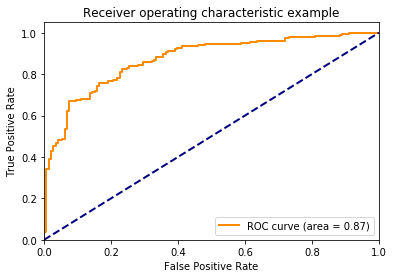

In [18]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(valid_labels, predictions)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('Receiver_operating_characteristic_example')

In the previous model we use ....,.... and got a $0.743$ auc score, which is relatively a good score. However, we'd still need to see what parameters play the biggest role in order for this model to learn. i.e. what parameters have biggest influence on updating the weights of this model. By doing so, we are also able to understand more about the data.

<br>

# Prediction Analysis

Let's now together examine the success of this model's predictions.<br>
Because the type of classificaiton is *binary*. i.e. the output is either $0$ or $1$ ('nonmutagen' or 'mutagen'), unlike in *multilabel classification* where the output can any float value ranging from $0$ to $1$, we can use a confusion matrix which shows true postives with respect to false postives, and true negatives with respect to false negatives - more on that in the following [**remark on Confusion Matrix**](Reading_sdf_file.ipynb#Remark-on-Confusion-Matrix).<br>

## Remark on Confusion Matrix:

Apparantly, the model has a lower chance of predicting nonmutagens than mutagens, indicated by the darker blue color on the plot above. Tweaking the parameters later, will help us find which input from bits has highest significance during prediction.

Interpreting the results above:
* In $64$ out of $181$ cases where the true label was '**mutagen**', the model predicted that it was '**nonmutagen**'.
* In $40$ cases the model predited it to be '**mutagen**', where the true label was '**nonmutagen**',.
* The rest of predictions were accurate.


# Hyperparameters Optimization

Neural Networks are notoriously difficult to configure and there are a lot of parameters that need to be set. Above all this, it's a very slow process to train and evaulate every model you build. Therefore, one can use optimization methods that allow faster hyperparameters substitution. Using these methods, we can acheive an automated optimization process.<br>
Specifically, I'll be using the grid search method, since Keras library has a plenty of grid-search capable functions.

Keras models can be used by wrapping them with the KerasClassifier. To use these wrappers we must define a function that creates and returns your Keras sequential model, then pass this function to the `build_fn` argument when constructing the KerasClassifier class.<br>
The constructor for the KerasClassifier class can take default arguments that are passed on to the calls to `model.fit()`, such as the number of epochs and the batch size.<br>
The constructor for the KerasClassifier class can also take newly specified arguments that can be passed to your custom `create_model()` function. These new arguments must also be defined in the signature of your `create_model()` function with default parameters.

We use average accuracy as an estimate for out-of-sample accuracy 

In [12]:
## Use scikit-learn to grid search the batch size and epochs
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.optimizers import SGD

In [13]:
def create_model(learn_rate=0.01, momentum=0, init_mode='uniform', activation='relu',
                dropout_rate=0.0, weight_constraint=0, neurons=1):
    '''Function to create model, required for KerasClassifier'''
    ## create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=8, kernel_initializer=init_mode, activation=activation,
                       kernel_constraint=maxnorm(weight_constraint)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    ## Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [14]:
## fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh',
              'sigmoid', 'hard_sigmoid']
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
neurons = [5, 10, 20, 50, 100, 200, 256, 512, 2048]

param_grid = dict(batch_size=batch_size, epochs=epochs, learn_rate=learn_rate, momentum=momentum,
                 init_mode=init_mode, activation=activation, dropout_rate=dropout_rate,
                  weight_constraint=weight_constraint, neurons=neurons)

## create model
model = KerasClassifier(build_fn=create_model, verbose=0)
## time the iterations
from datetime import datetime
start=datetime.now()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1) # -1 to run in parallel
grid_result = grid.fit(valid_samples, valid_labels)
print(datetime.now()-start)

## summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KeyboardInterrupt: 

The following cell is just in order for me to transfer the bits data to another machine, without having to recalculate them.<br>
The cell is saved in raw format, because I've already run the code. If you'd like to overwrite the files, rerun the cell.

In [12]:
## save data for easy reproduction
np.savetxt("data/train_samples.txt", train_samples , delimiter=' ', comments='# ', encoding=None)
np.savetxt("data/train_labels.txt", train_labels , delimiter=' ', comments='# ', encoding=None)
np.savetxt("data/valid_samples.txt", valid_samples , delimiter=' ', comments='# ', encoding=None)
np.savetxt("data/valid_labels.txt", valid_labels , delimiter=' ', comments='# ', encoding=None)

In [25]:
train_whatever == train_samples

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>



---
<div style="text-align: center;"> <b>Please ingore everything below this here<b>
    
    |
    |
    |
    |
    |
    ٧
</div>

---

## Second Model

Let's take a look on what things that are featurign this model. This model has ... learning rate instead of .... and instead .. and unline in the previous one it has ... instead .... . So how does this model comapre to the previous one in terms of accuracy, prediction, and auc score.

The following is a table that shows the comparison of all models. Learning rate, model architecture and and wether or not Dropout was used, are all depicted for each model:

|Model_nr|Learning Rate|Dropout|Nom of layers |Activation Functions|       OutputLayer        |
|--------|-------------|-------|--------------|--------------------|--------------------------|
|1       |0.01         |no     |1 hidden layer|relu                |one-dimensional output dense with linear activation|
|2       |

Additionally, you can refer to the model's summary by ty

In [ ]:
model = Sequential([
    Dense(16, input_shape=(4337, 2048,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
])

In [ ]:
model.compile(Adam(lr=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [73]:
train_labels

array([1., 1., 0., ..., 0., 0., 0.])

In [79]:
count=0
for i in train_labels:
    if i == 0:
        count += 1